## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [1]:
from main import *
ari = ARI()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.0+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [2]:
case1, case2 = ari.load_data()

case1_qinv = ari.quadratic_inversion(case1)
case2_qinv = ari.quadratic_inversion(case2)

In [33]:
def plot_inversion_results(inv, figsize=(15,12)):
    fig, axs = plt.subplots(1, 5, figsize=figsize, sharey=True, facecolor='white')
    ax1, ax2, ax3, ax4, ax5 = axs
    ax11, ax12 = ax1.twiny(), ax1.twiny()
    ari.plot_curve(ax1,  inv, 'GR',      lb=0, ub=150, color='g',    units='API',  pad=0)
    ari.plot_curve(ax11, inv, 'Csh_lin', lb=0, ub=1,   color='gray', units='frac', pad=8)
    ari.plot_curve(ax12, inv, 'Csh',     lb=0, ub=1,   color='k',    units='frac', ls='--', pad=16)

    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax2,  inv, 'AT10', lb=0.2, ub=200, color='r', units='$\Omega.m$', semilog=True, pad=0)
    ari.plot_curve(ax21, inv, 'AT90', lb=0.2, ub=200, color='b', units='$\Omega.m$', semilog=True, pad=8)
    ari.plot_curve(ax22, inv, 'Rs',   lb=0.2, ub=200, color='k', units='$\Omega.m$', alpha=0.75, semilog=True, pad=16)

    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax3,  inv, 'Rv',     lb=0.2, ub=100, color='darkred',  units='$\Omega.m$',   semilog=True, pad=0)
    ari.plot_curve(ax31, inv, 'Rv_sim', lb=0.2, ub=100, color='k', units='$\Omega.m$', ls='--', alpha=0.75, semilog=True, pad=8)
    ari.plot_curve(ax32, inv, 'Rv_err', lb=1e-9, ub=100, color='red', units='%', alpha=0.5, pad=16)

    ax41, ax42 = ax4.twiny(), ax4.twiny()
    ari.plot_curve(ax4,  inv, 'Rh',     lb=0.2, ub=100, color='darkblue',  units='$\Omega.m$',  semilog=True, pad=0)
    ari.plot_curve(ax41, inv, 'Rh_sim', lb=0.2, ub=100, color='k', units='$\Omega.m$', alpha=0.75, ls='--', semilog=True, pad=8)
    ari.plot_curve(ax42, inv, 'Rh_err', lb=1e-9, ub=100, color='blue', units='%', alpha=0.5, pad=16)

    ax51, ax52 = ax5.twiny(), ax5.twiny()
    ari.plot_curve(ax5,  inv, 'fun',      lb=0, ub=0.6,  color='k', pad=0)
    ari.plot_curve(ax51, inv, 'nfev',     lb=50, ub=350, color='g', alpha=0.75, pad=8)
    ari.plot_curve(ax52, inv, 'norm_jac', lb=0,  ub=30,  color='m', alpha=0.75, pad=16)

    ax1.set_ylabel('Depth [ft]')
    plt.gca().invert_yaxis()
    plt.show()

In [60]:
def resistivity_inversion(df, 
                          Wd_matrix:bool=True, lambda_reg=0, x0=[0.5,1,1,1], method='L-BFGS-B',
                          tolerance=1e-6, maxiter=100):
    df['Csh_lin'] = (df['GR'] - df['GR'].min()) / (df['GR'].max() - df['GR'].min())
    
    def objective(variables, *args):
        Csh, Rs, Rvsh, Rhsh = variables
        Rv,  Rh = args[0], args[1]
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        eqs = [eq1*Rv, eq2*Rh] if Wd_matrix else [eq1, eq2]
        return linalg.norm(eqs,2)**2 + lambda_reg*linalg.norm(variables,2)**2
    
    def inversion():
        res_aniso = df[['Rv','Rh']]
        sol, fun, jac, nfev = [], [], [], []
        for _, row in res_aniso.iterrows():
            Rv_value, Rh_value = row['Rv'], row['Rh']
            solution = optimize.minimize(objective,
                                        x0      = x0,
                                        args    = (Rv_value, Rh_value),
                                        jac     = '3-point',
                                        bounds  = [(0,1), (None,None), (None,None), (None,None)],
                                        method  = method,
                                        tol     = tolerance,
                                        options = {'maxiter':maxiter})
            fun.append(solution.fun); jac.append(solution.jac); nfev.append(solution.nfev)
            jac1, jac2 = np.array(jac)[:,0], np.array(jac)[:,1]
            sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                        'Csh':solution.x[0], 'Rs':solution.x[1],
                        'Rvsh':solution.x[2], 'Rhsh':solution.x[3]})
        sol = pd.DataFrame(sol, index=res_aniso.index)
        sol['fun'], sol['nfev'], sol['jac1'], sol['jac2'], sol['norm_jac'] = fun, nfev, jac1, jac2, linalg.norm(jac, axis=1)
        return sol
    
    def simulate(sol):
        Csh, Rs, Rvsh, Rhsh = sol['Csh'], sol['Rs'], sol['Rvsh'], sol['Rhsh']
        Rv_sim = Csh*Rvsh + (1-Csh)*Rs
        Rh_sim = Csh/Rhsh + (1-Csh)/Rs
        sim = pd.DataFrame({'Rv_sim':Rv_sim, 'Rh_sim':1/Rh_sim}, index=sol.index)
        return sim
    
    def error(sol, sim):
        Rv_true, Rh_true = sol['Rv'], sol['Rh']
        Rv_pred, Rh_pred = sim['Rv_sim'], sim['Rh_sim']
        Rv_err = np.abs((Rv_pred - Rv_true) / Rv_true) * 100
        Rh_err = np.abs((Rh_pred - Rh_true) / Rh_true) * 100
        res = pd.DataFrame({'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=sol.index)
        return res
    
    val = df[['AT10','AT30','AT60','AT90','GR','Csh_lin']]
    sol = inversion()
    sim = simulate(sol)
    err = error(sol, sim)
    res_inv = val.join(sol).join(sim).join(err)
    return res_inv

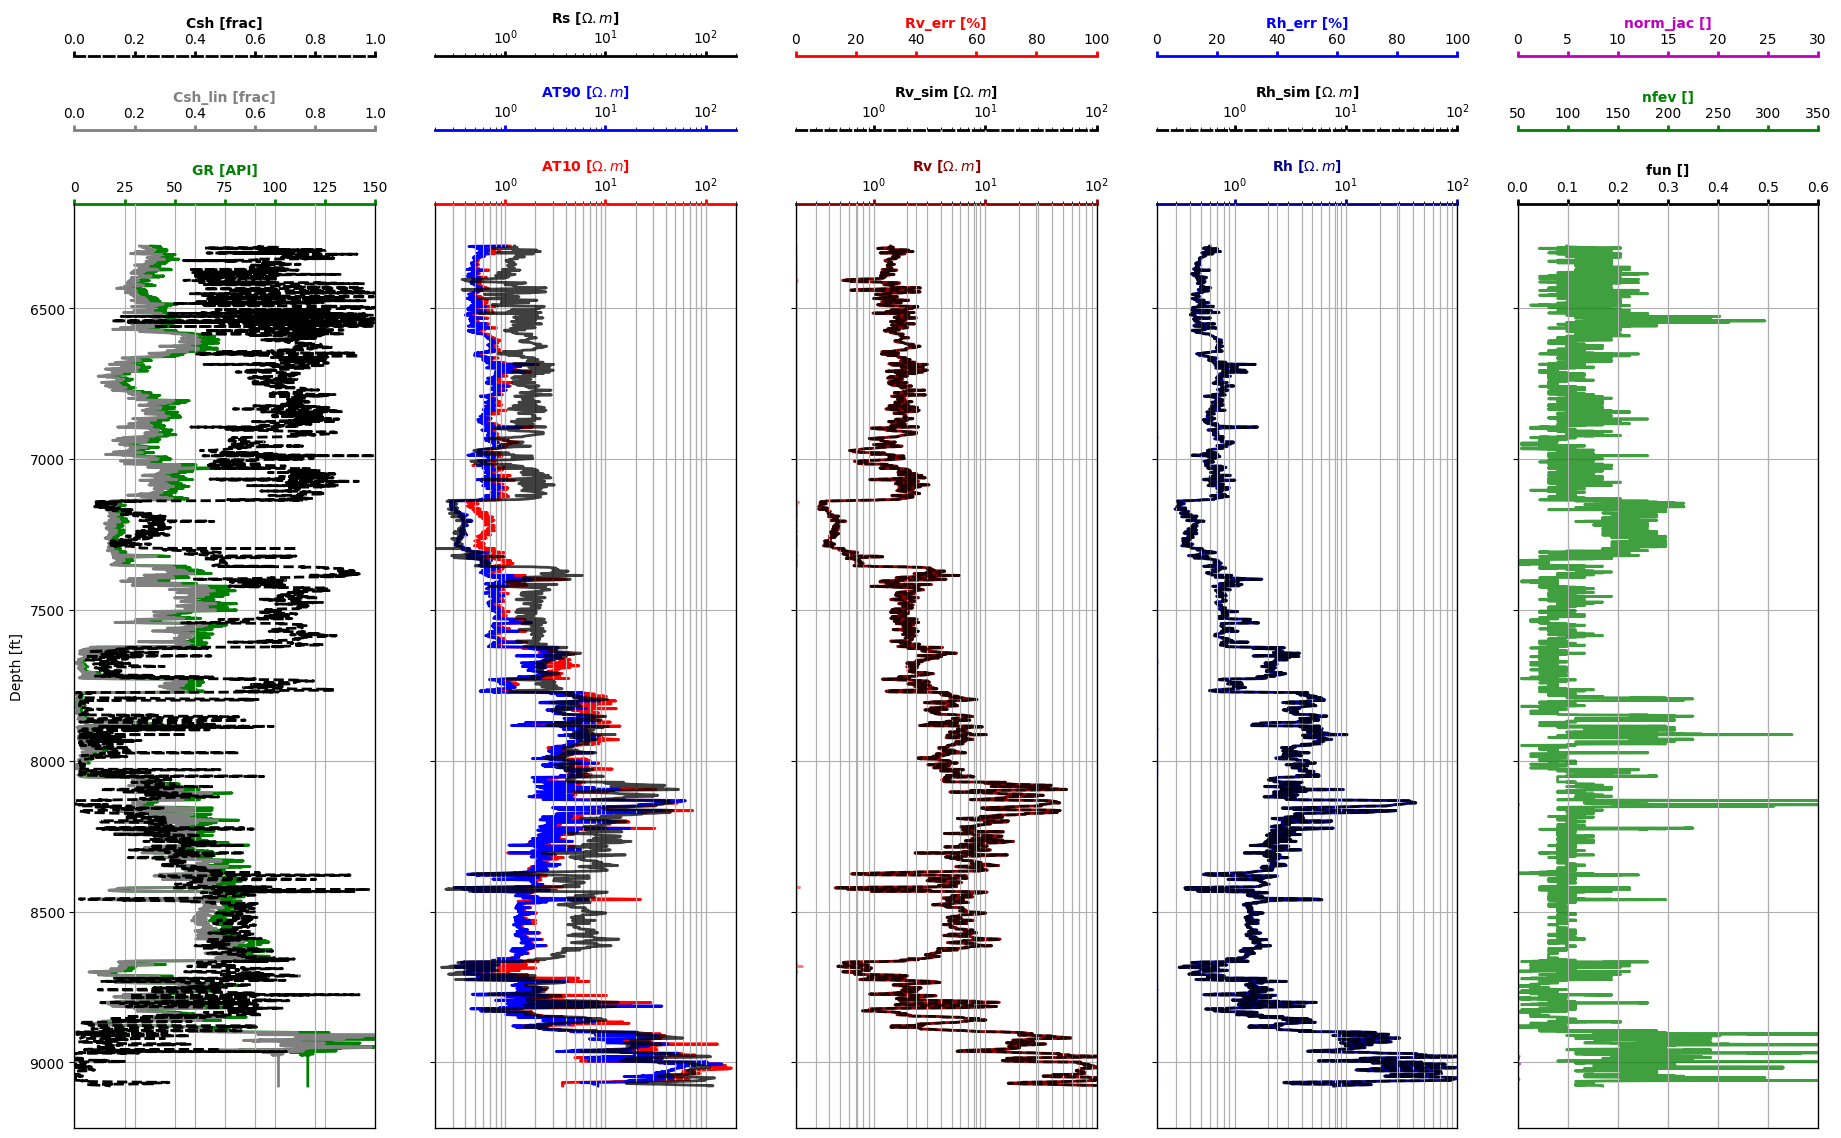

In [62]:
inv = resistivity_inversion(case2)
plot_inversion_results(inv, figsize=(22.5,12))

***
# END

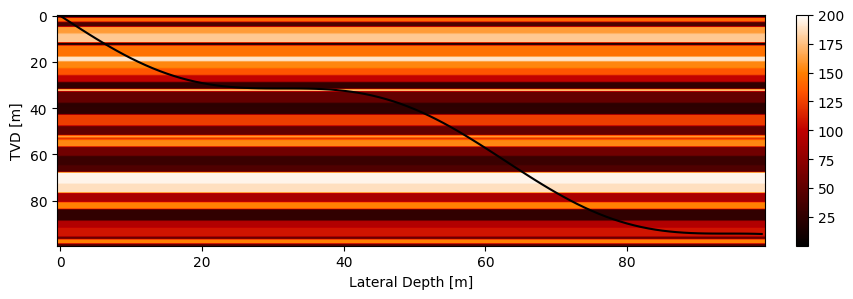

In [245]:
num_layers = 50
rmin, rmax= 0.2, 200

model = np.zeros((100,1))
layer_value = np.random.uniform(rmin, rmax, num_layers)
layer_thick = np.random.uniform(0.1, 5, num_layers)

for i in range(100):
    for j in range(num_layers):
        if i > np.sum(layer_thick[:j]):
            model[i] = layer_value[j]
model = np.repeat(model, 100, 1)

x = np.arange(100)
y = x + 10*np.sin(x/10)

plt.figure(figsize=(10,3))
im = plt.imshow(model, cmap='gist_heat', vmin=rmin, vmax=rmax, aspect='auto')
plt.plot(x, y, 'k')
cb = plt.colorbar(im, pad=0.04, fraction=0.046)
plt.ylabel('TVD [m]'); plt.xlabel('Lateral Depth [m]')
plt.show()